In [93]:
import gymnasium as gym
import torch as t
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [68]:
env = gym.make("CartPole-v1", render_mode=None)
vars(env)
device = "cpu"

In [183]:
class Model(nn.Module):
    def __init__(self, device):
        super(Model, self).__init__()
        self.network = nn.Sequential(
        nn.Linear(4, 128),
        nn.ReLU(),
        nn.Linear(128,2),
        nn.Softmax()
        )
        self.device = device
    
    def forward(self, x):
        return self.network(x.to(self.device))


    
# targetNetwork.load_state_dict(deepcopy(model.state_dict()))
optimizer = t.optim.Adam(model.parameters(), lr=0.1)

In [160]:
optimizer = t.optim.Adam(model.parameters(), lr=1)

In [170]:
def sig_to_binary(output, threshold=0.5):
        return 1 if output >= threshold else 0

def toggle01(zero_or_one):
    return 1 - zero_or_one

def tensor(data, device="cpu"):
    return t.tensor([data], device=device, dtype=t.float32)

def trainModel(model, pred, action, loss_fn, optimizer, fail, device):
    # if fail == True:
        # loss = loss_fn(pred, tensor(toggle01(action), device))
        # print(f"pred: {pred.item()} --- action: {toggle01(action)} --- {fail} --- {loss.item()}")
    # elif fail == False:
        # loss = loss_fn(pred, tensor(action, device))
        # print(f"pred: {pred.item()} --- action: {action} --- {fail} ---{loss.item()}")
    loss = tensor([-1])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
def trainModel2(preds, optimizer, total_reward):
    #print(t.cat(preds, 0), end="\r")
    loss = t.cat(preds, 0) * -total_reward
    # print(loss, end="\n")
    optimizer.zero_grad()
    loss.sum().backward()
    optimizer.step()
    
def punishModel3(preds, optimizer, punish):
    loss = t.cat(preds, 0) * punish
    optimizer.zero_grad()
    loss.sum().backward()
    optimizer.step()
    
def trainWithTargetNetwork(targets, preds, optimizer, reward, sync_counter, target_network):
    loss = nn.functional.mse_loss(t.cat(preds, 0), t.cat(targets, 0))
    _wtfone= loss
    loss = loss - reward
    _wtftwo = loss
    print(_wtfone, _wtftwo, end="\r")
    optimizer.zero_grad()
    loss.sum().backward()
    optimizer.step()
    
    if sync_counter >= 50:
        target_network.load_state_dict(deepcopy(model.state_dict()))
        sync_counter = -1
    return sync_counter + 1


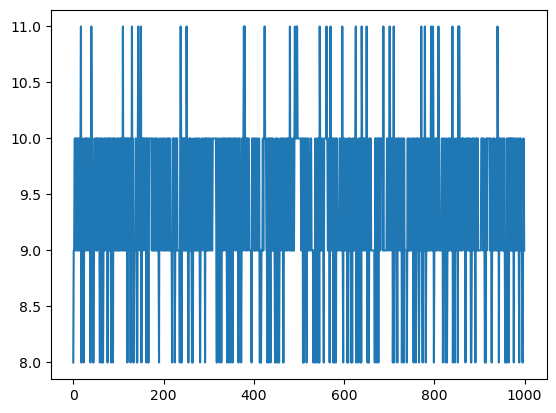

In [185]:
state, info = env.reset()
total_reward = 0
epochs = 1000
rewards_per_epoch = np.empty(epochs)
i = 0
preds = []
targets = []
max_reward = 0
sync_counter = 0
while i < epochs:
    #action = env.action_space.sample()  # agent policy that uses the observation and info
    pred, action = t.max(model(tensor(state)), 1)
    target, _ = t.max(targetNetwork(tensor(state)),1)
    preds.append(pred)
    targets.append(target)
    state, reward, terminated, truncated, info = env.step(action.item())
    total_reward = total_reward + reward
    
    # trainModel(model, pred, action, loss_fn, optimizer, terminated, device)
    # print(observation, reward, terminated, truncated)
    if terminated or truncated:
        # print(sync_counter)
#         sync_counter = trainWithTargetNetwork(targets, preds, optimizer, total_reward,
#                                              sync_counter, targetNetwork)
        
#         rewards_per_epoch[i] = total_reward
        # # print(total_reward, i, end="\r")
        # state, info = env.reset()
        # preds = []
        # targets = []
        # total_reward = 0
        # i = i + 1
        
        if total_reward < 300:
            if total_reward >= max_reward - (max_reward * 0.25):
                max_reward = max(max_reward, total_reward)
                trainModel2(preds, optimizer, total_reward)
            else:
                trainModel2(preds, optimizer, -total_reward)   
            rewards_per_epoch[i] = total_reward
            print(total_reward, i, end="\r")
            state, info = env.reset()
            preds = []
            total_reward = 0
            i = i + 1
        else:
            break

env.close()
plt.plot(rewards_per_epoch)
plt.show()
plt.close()
# beep(3)

In [110]:
(model(tensor([5,5,5,5])) * -200).backward()
optimizer.step()
optimizer.zero_grad()


RuntimeError: grad can be implicitly created only for scalar outputs

In [22]:
for name, param in model.named_parameters():
    print(name, param)

network.0.weight Parameter containing:
tensor([[-0.1286,  0.1222,  0.1900, -0.5425],
        [ 0.5962,  0.5067,  0.1174,  0.3962],
        [-0.0995,  0.2614,  0.3049,  0.0874],
        [ 0.0110,  0.3365, -0.1983,  0.3895],
        [ 0.2935,  0.4468, -0.3151, -0.1703],
        [-0.0854, -0.3905,  0.1440,  0.4799],
        [-0.2594,  0.2760, -0.4215, -0.0377],
        [-0.0336, -0.2520,  0.4281,  0.6289],
        [-0.1371, -0.0405, -0.2739,  0.2641],
        [-0.3784, -0.2936,  0.3936, -0.1831],
        [ 0.0192, -0.2504, -0.3619, -0.3950],
        [ 0.4269, -0.0035, -0.3111,  0.3157]], requires_grad=True)
network.0.bias Parameter containing:
tensor([ 0.0402, -0.2258,  0.3728,  0.3944,  0.1325, -0.4909,  0.4493, -0.0702,
        -0.2457, -0.1606,  0.0732,  0.3457], requires_grad=True)
network.2.weight Parameter containing:
tensor([[ 0.2184, -0.1874,  0.2001, -0.1294,  0.2379,  0.1716,  0.2469,  0.3418,
         -0.0607, -0.0896,  0.0787, -0.0370],
        [-0.1672,  0.0685,  0.0981,  0.1

In [55]:
#past a certain state, you'll always lose no matter the action. Therefore, you shouldn't positively reinforce 
#any actions past that point
#exploration vs exploitation
gayass = t.cat([tensor([5]), tensor([6]), tensor([8])], dim=0)

In [160]:
x = model(tensor([5 ,5,5,5]))

In [88]:
t.max(x, 1)

torch.return_types.max(
values=tensor([0.6008], grad_fn=<MaxBackward0>),
indices=tensor([0]))

In [79]:
wut = []

In [80]:
wut.append(5)

In [77]:
max_reward

11.0

In [82]:
gayass * -9

tensor([[-45.],
        [-54.],
        [-72.]])

In [83]:
x * -19

tensor([-11.4150], grad_fn=<MulBackward0>)

In [84]:
x

tensor([0.6008], grad_fn=<MaxBackward0>)

In [76]:
y

tensor([0, 0])

In [38]:
max((1,2,5))

5

In [163]:
x - x - 13

tensor([[-13., -13.]], grad_fn=<SubBackward0>)

In [85]:
testenv = gym.make("CartPole-v1", render_mode="human")
state, info = testenv.reset()

total_reward = 0
terminated = False
while not terminated:
    testenv.render()
    with t.no_grad():
        pred, action = t.max(model(tensor(state)), 1)
        
    state, reward, terminated, truncated, info = testenv.step(action.item())
    total_reward = total_reward + reward

testenv.close()
print(total_reward)

52.0


In [54]:
env.close()